In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets,models,transforms
from torchvision.utils import make_grid

In [2]:
train_transform = transforms.Compose([
    
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.Grayscale(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    
])

In [3]:
test_transform = transforms.Compose([
    
    transforms.Grayscale(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    
])

In [4]:
path = "V:\\projects\\corona mask detector\\dataset\\"

In [5]:
train_data = datasets.ImageFolder(root=path + "train",transform=train_transform)
test_data = datasets.ImageFolder(root=path + "test",transform=test_transform)

In [6]:
print(train_data.class_to_idx)
print(test_data.class_to_idx)

{'with mask': 0, 'without mask': 1}
{'with mask': 0, 'without mask': 1}


In [7]:
torch.manual_seed(59)
train_loader = DataLoader(train_data,batch_size = 10,shuffle = True)
test_loader = DataLoader(test_data,batch_size = 50,shuffle = False)

In [8]:
print(len(train_data))
print(len(test_data))

1117
259


In [9]:
for i,j in train_loader:
    print(i,j)
    break

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.9412, 0.9373, 0.9373],
          [0.0000, 0.0000, 0.0000,  ..., 0.9451, 0.9529, 0.9725],
          [0.0000, 0.0000, 0.0000,  ..., 0.9804, 0.9843, 0.9804],
          ...,
          [0.9216, 0.9216, 0.8824,  ..., 0.0000, 0.0000, 0.0000],
          [0.9059, 0.9020, 0.8941,  ..., 0.0000, 0.0000, 0.0000],
          [0.8902, 0.8863, 0.8706,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0980, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0980, 0.0000, 0.0000],
          [0.1255, 0.1294, 0.1294,  ..., 0.1020, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0510,  ..., 0.0784, 0.0784, 0.0745],
          [0.0000, 0.0000, 0.0431,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0549,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

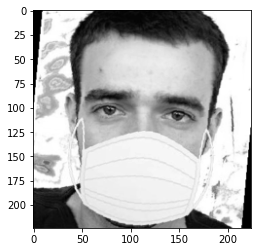

In [10]:
##default color
plt.imshow(i[4].reshape(224,224),cmap="gray")

In [11]:
class convnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1) ##(((224-2)/1)-1)/2
        self.conv2 = nn.Conv2d(6,16,3,1) ##((((224-2)-1)/2-2)-1)/2
        self.fc1 = nn.Linear(54*54*16,120)
        self.fc2 = nn.Linear(120,32)
        self.fc3 = nn.Linear(32,2)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,54*54*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x),dim = 1)
        

In [12]:
model = convnet()

In [13]:
model.cuda()

convnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [15]:
import time

start_time = time.time()
epochs = 8
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(epochs):
    trn_acc = 0
    tst_acc = 0
    for b,(x_train,y_train) in enumerate(train_loader): 
        b += 1
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        
        y_pred = model.forward(x_train)
        loss = criterion(y_pred,y_train)
        
        pred = torch.max(y_pred,1)[1]
        trn_acc += (pred == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%50 == 0:
            print(f"loss in epoch&bacth-->{epoch}:{b} is {loss}")
            
    train_loss.append(loss)   
    train_acc.append(trn_acc)
    
    with torch.no_grad():
        for b,(x_test,y_test) in enumerate(test_loader):
            
            b += 1
            x_test = x_test.cuda()
            y_test = y_test.cuda()
            
            y_val = model.forward(x_test)
            predicted = torch.max(y_val.data, 1)[1] 
            tst_acc += (predicted == y_test).sum()
            loss = criterion(y_val,y_test)
            
            if b%50 == 0:
                print(f"test_loss in epoch&b-->{epoch}:{b}")
            
            test_loss.append(loss)      
        
    test_acc.append(tst_acc)



print(f"total time taken is {(start_time - time.time())/60}")

loss in epoch&bacth-->0:50 is 0.4693613648414612
loss in epoch&bacth-->0:100 is 0.19372178614139557
loss in epoch&bacth-->1:50 is 0.053408183157444
loss in epoch&bacth-->1:100 is 0.23349475860595703
loss in epoch&bacth-->2:50 is 0.447702020406723
loss in epoch&bacth-->2:100 is 0.011390593834221363
loss in epoch&bacth-->3:50 is 0.024431869387626648
loss in epoch&bacth-->3:100 is 0.0936623364686966
loss in epoch&bacth-->4:50 is 0.010631180368363857
loss in epoch&bacth-->4:100 is 0.027463948354125023
loss in epoch&bacth-->5:50 is 0.04055734723806381
loss in epoch&bacth-->5:100 is 0.004491864237934351
loss in epoch&bacth-->6:50 is 0.11460419744253159
loss in epoch&bacth-->6:100 is 0.036168694496154785
loss in epoch&bacth-->7:50 is 0.13387341797351837
loss in epoch&bacth-->7:100 is 0.014949897304177284
total time taken is -1.3211194713910421


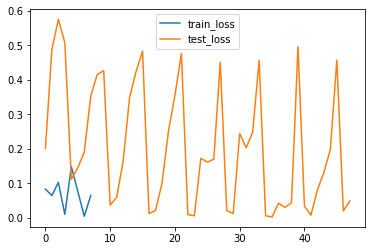

In [16]:
plt.plot(train_loss,label = "train_loss")
plt.plot(test_loss,label = "test_loss")
plt.legend()
plt.show()

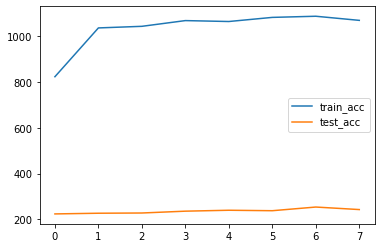

In [17]:
plt.plot(train_acc,label = "train_acc")
plt.plot(test_acc,label = "test_acc")
plt.legend()
plt.show()

In [18]:
from PIL import Image
im = Image.open('V:\\projects\\corona mask detector\\dataset\\train\\with mask\\19-with-mask.jpg') 

In [19]:
trans = transforms.Compose([
    
    transforms.Grayscale(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
    
])

In [20]:
timg = trans(im)

In [21]:
timg = timg.reshape(1,1,224,224) 

In [22]:
timg.shape

torch.Size([1, 1, 224, 224])

In [23]:
x_test.shape

torch.Size([9, 1, 224, 224])

In [25]:
with torch.no_grad():
    y_pred = model.forward(timg.cuda())

In [26]:
y_pred.argmax()

tensor(0, device='cuda:0')

In [28]:
PATH = 'V:\\projects\\corona mask detector\\mask.pt'

In [29]:
torch.save(model.state_dict(), PATH)